In this tutorial we will generate interaction fingerprints to compare the structure of a hit from a fragment screen with a set of analogs that were generated by [CReM](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00431-w) and subsequenntly docked.  We begin by reading in the structure of the original fragment hit and the analogs.  We then calculate the RMSD between the fragment and each of the analogs. This provides an indicator of how well the pose of the original fragment is preserved in the docked analog. Finally, we use ProLif to generate interaction fingerprints that can be used to determine which analogs are making new interactions. 

In [22]:
from rdkit import Chem
from rdkit.Chem import PandasTools 
import useful_rdkit_utils as uru
import seaborn as sns
import prolif as plf
from tqdm.auto import tqdm
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
import numpy as np

Read the structure of the reference fragment.  This is the ligand from [6g92](https://www.rcsb.org/structure/6G92), an inhibitor of ERK2. 

In [23]:
ref_mol = Chem.MolFromMolFile("6g92_ligand.sdf")

Read the structures of the docked analogs.

In [24]:
df = PandasTools.LoadSDF("crem_analogs_docked.sdf")

Calculate the RMSD between the reference ligand and the analogs. This cacluation uses the [mcs_rmsd]() function from useful_rdkit_utils.  The function first calcuates the maximum common substructure (MCS) between the reference and the analog, then calculates the root mean squared deviation (RMSD) between the corresponding atoms. 

In [25]:
df['RMSD'] = [uru.mcs_rmsd(ref_mol, x)[1] for x in df.ROMol]

Plot the RMSD distribution. 

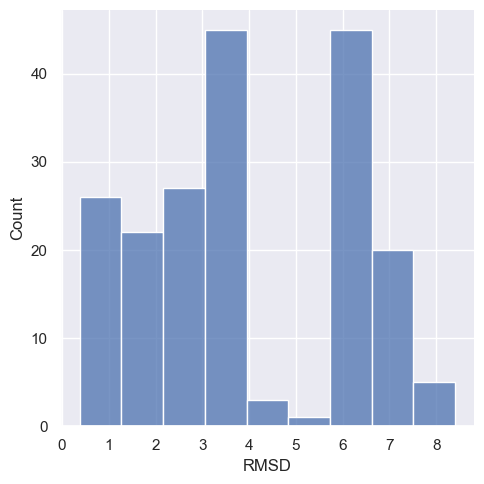

In [26]:
sns.displot(df.RMSD)

Display the results. 

,meeko,vina_energy,ID,ROMol,RMSD
0,"{""is_sidechain"": false}",-7.34,,,0.559511
1,"{""is_sidechain"": false}",-6.58,,,7.895644
2,"{""is_sidechain"": false}",-6.45,,,7.915742
3,"{""is_sidechain"": false}",-7.00,,,1.286238
4,"{""is_sidechain"": false}",-6.86,,,1.276432
...,...,...,...,...,...
189,"{""is_sidechain"": false}",-6.36,,,6.086236
190,"{""is_sidechain"": false}",-6.37,,,2.946889
191,"{""is_sidechain"": false}",-5.83,,,6.325580
192,"{""is_sidechain"": false}",-7.36,,,1.407290

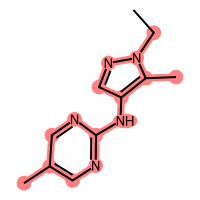
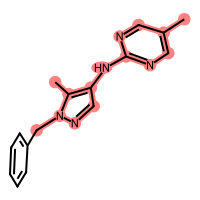
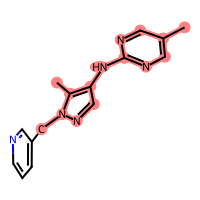
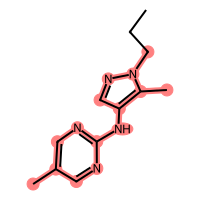
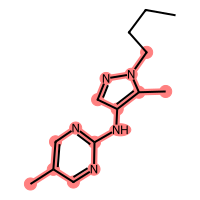
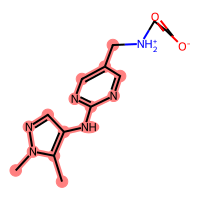
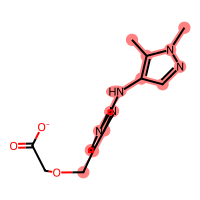
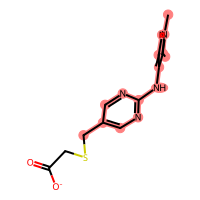
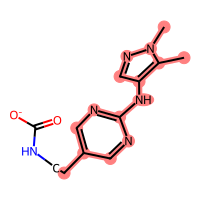
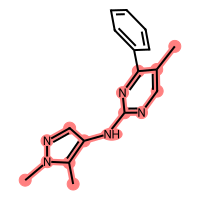

In [27]:
df

View the overlap between the reference ligand and the second analog. 

In [28]:
uru.mol_to_3D_view([ref_mol,df.ROMol.values[0]])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

View the overlap between the reference ligand and the second analog. 

In [29]:
uru.mol_to_3D_view([ref_mol,df.ROMol.values[1]])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Filter the dataframe and only keep analogs with RMSD < 1.0 A.

In [30]:
df_ok = df.query("RMSD <= 1.0")

In [31]:
len(df_ok)

19

Write the low RMSD analogs to disk.

In [11]:
with Chem.SDWriter("crem_docked_rmsd_filtered.sdf") as writer:
    for mol in [ref_mol] + list(df_ok.ROMol.values):
        writer.write(mol)

Setup the inputs for ProLif.

In [32]:
PDB_FILEPATH = "6g92_protein_fixed.pdb"
SDF_FILEPATH = "crem_docked_rmsd_filtered.sdf"

Calculate the interaction fingerprints. 

In [43]:
fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(SDF_FILEPATH)
fp.run_from_iterable(suppl,prot,progress=True)
fp_df = fp.to_dataframe()
fp_df.columns = fp_df.columns.droplevel(0)
fp_df

  0%|          | 0/20 [00:00<?, ?it/s]

protein         ILE31.A                VAL39.A                ALA52.A  \
interaction Hydrophobic VdWContact Hydrophobic VdWContact Hydrophobic   
Frame                                                                   
0                  True      False        True      False        True   
1                  True       True        True      False        True   
2                  True       True        True      False        True   
3                  True       True        True      False        True   
4                  True       True        True      False        True   
5                  True       True        True      False        True   
6                  True       True        True      False        True   
7                  True       True        True      False        True   
8                  True       True        True       True        True   
9                  True       True        True       True        True   
10                 True       True        True       True        True   
11                 True       True        True       True        True   
12                 True       True        True       True        True   
13                 True       True        True       True        True   
14                 True       True        True      False        True   
15                 True       True        True      False        True   
16                 True       True        True       True        True   
17                 True       True        True      False        True   
18                 True       True        True       True        True   
19                 True       True        True      False        True   

protein                   LYS54.A     ILE84.A               GLN105.A  ...  \
interaction VdWContact VdWContact Hydrophobic VdWContact Hydrophobic  ...   
Frame                                                                 ...   
0                 True      False       False      False       False  ...   
1                False      False       False      False       False  ...   
2                False      False       False      False       False  ...   
3                False      False       False      False       False  ...   
4                False      False       False      False       False  ...   
5                False      False       False      False       False  ...   
6                False      False       False      False       False  ...   
7                False      False       False       True       False  ...   
8                 True       True       False      False       False  ...   
9                 True       True       False      False       False  ...   
10                True      False       False       True       False  ...   
11               False       True       False      False       False  ...   
12               False       True       False      False       False  ...   
13               False      False        True       True        True  ...   
14               False       True       False      False       False  ...   
15                True      False       False      False       False  ...   
16               False       True       False      False       False  ...   
17               False      False       False      False       False  ...   
18               False       True       False      False       False  ...   
19                True      False       False      False       False  ...   

protein       HOH667.A              HOH724.A              HOH731.A   HOH761.A  \
interaction HBAcceptor VdWContact HBAcceptor VdWContact VdWContact VdWContact   
Frame                                                                           
0                False      False       True       True      False      False   
1                False      False       True       True      False      False   
2                False      False       True       True       True      False   
3                False      False       True       True       

Plot the interaction fingerprints as a heatmap.

In [44]:
sns.set(rc = {'figure.figsize':(15,8)})

Text(0.5, 55.249999999999986, 'Protein Interaction')

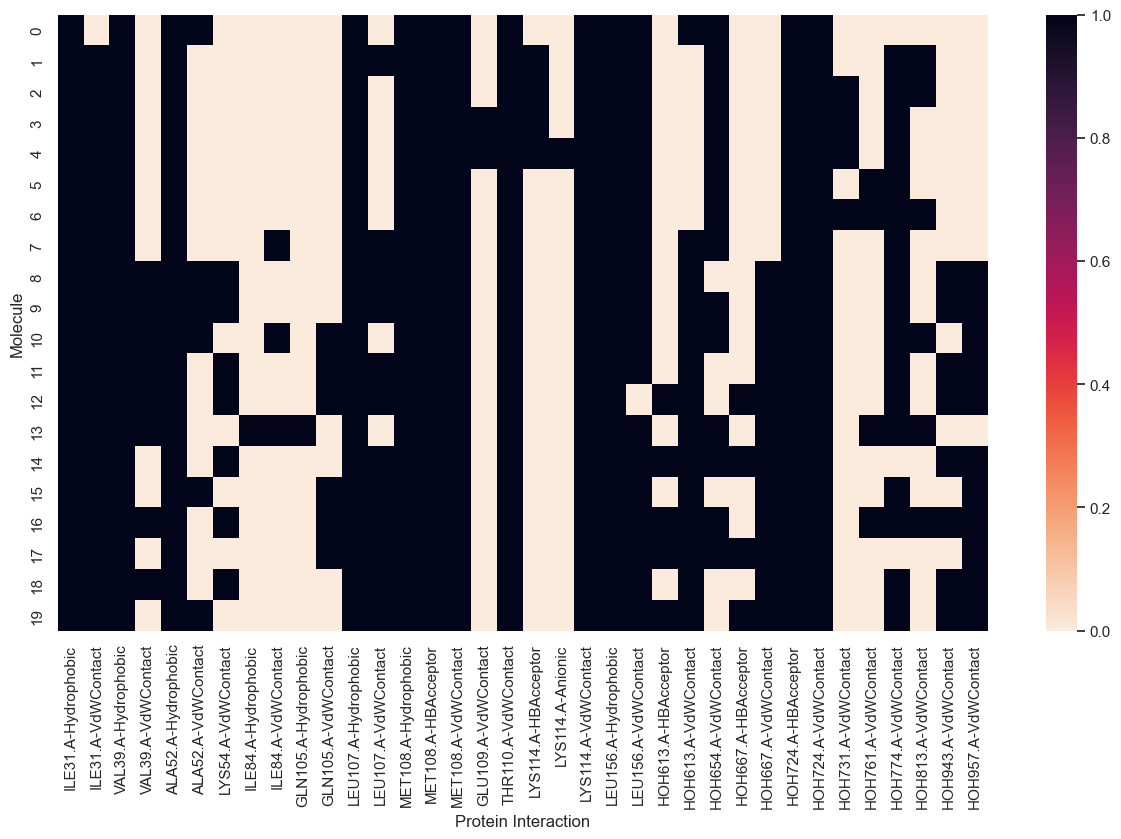

In [45]:
ax = sns.heatmap(fp_df,cmap=sns.cm.rocket_r)
ax.set_ylabel("Molecule")
ax.set_xlabel("Protein Interaction")

At this point, we'd like to cluster the dataset based on interaction fingerprints.  This enables us to cluster the data and group compounds making similar interactions. First, we will convert the interaction fingerprints to a format the can be processed by the RDKit. 

In [48]:
fp_list = fp.to_bitvectors()

Cluster the fingerprints and display a heatmap. 

/var/folders/nt/jm11nt2n47j1bwkv659008hr0000gn/T/ipykernel_9965/4050947766.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  sorted_df = fp_df.sort_values('cluster').drop("cluster",axis=1)


<Axes: xlabel='protein-interaction', ylabel='Frame'>

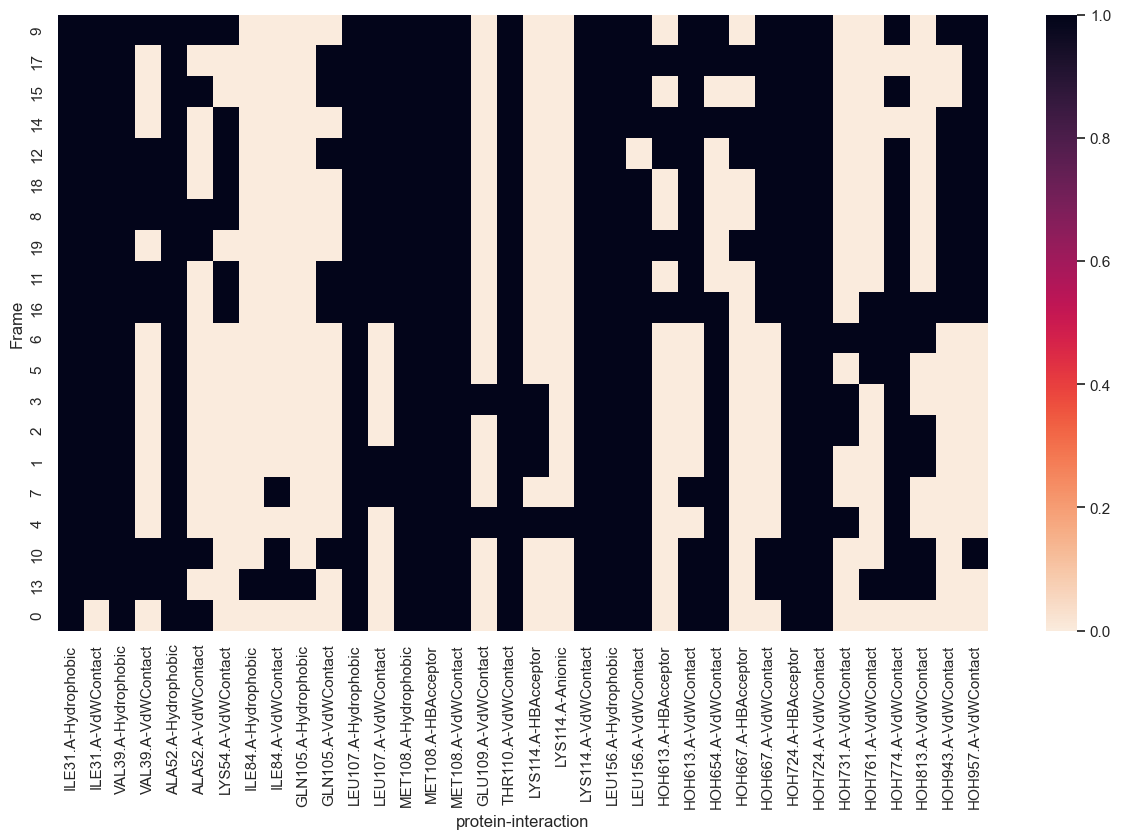

In [49]:
fp_df['cluster'] = uru.taylor_butina_clustering(fp_list,cutoff=0.2)
sorted_df = fp_df.sort_values('cluster').drop("cluster",axis=1)
sns.heatmap(sorted_df,cmap=sns.cm.rocket_r)